# Jakarta Coffee Shop Site Selection - Exploratory Data Analysis

**Project**: Location Intelligence Platform MVP

**Goal**: Analyze 2.5M+ Jakarta POIs to build predictive model for optimal coffee shop locations

**Data Sources**:
- Foursquare Open Source Places: 2,553,079 POIs
- OpenStreetMap: 5,071 POIs
- OSM Buildings: 5,624 buildings
- WorldPop: Population density raster
- GADM: Administrative boundaries
- BPS: Demographics

---

## Best Practices Applied (from Research)

### 1. Feature Engineering Strategy
Based on Beijing coffee shop study (MDPI 2023):
- **23 initial factors** from 20 POI types
- **150m buffer** from main roads (81% of shops)
- **12km radius** from city center (85% concentration)
- Feature importance filtering (>0.5 threshold)

### 2. Grid-Based Analysis
From Luckin/Starbucks Shanghai study (MDPI 2025):
- **100m x 100m grid** for consistent spatial analysis
- **1000m radius** analysis window for features
- Multi-source data overlay on grid centers

### 3. Model Approach
- **Random Forest** (best performer: R²=0.929, accuracy 90-92%)
- **XGBoost** (94% accuracy)
- **SHAP** for feature interpretation
- 70:30 train-test split
- Forward feature selection

### 4. Key Features (from Literature)
**High Priority**:
- Universities/campuses proximity
- Office buildings density
- Shopping malls distance
- Transportation hubs (MRT/KRL)
- Competitor density
- Population density
- Commercial residence count

**Spatial Features**:
- Proximity (distance to nearest)
- Density (count within radius)
- Summary statistics (mean, std within buffer)
- Spatial lag (neighborhood averages)

---

## 1. Setup and Data Loading

In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import geopandas as gpd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Spatial analysis
from shapely.geometry import Point, Polygon
import rasterio
from rasterio.plot import show
from libpysal.weights import DistanceBand
from esda.moran import Moran

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium.plugins import HeatMap, MarkerCluster

# Config
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Constants
PROJECT_ROOT = Path('D:/Script/Project/POI')
DATA_DIR = PROJECT_ROOT / 'data' / 'processed'
JAKARTA_BBOX = {
    'min_lat': -6.4, 'max_lat': -6.0,
    'min_lon': 106.6, 'max_lon': 107.1
}

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Directory: {DATA_DIR}")
print(f"Jakarta Bbox: {JAKARTA_BBOX}")

Project Root: D:\Script\Project\POI
Data Directory: D:\Script\Project\POI\data\processed
Jakarta Bbox: {'min_lat': -6.4, 'max_lat': -6.0, 'min_lon': 106.6, 'max_lon': 107.1}


### 1.1 Load Foursquare POI Data (2.5M POIs)

In [4]:
# Load Foursquare data (CSV is faster than GeoJSON for large files)
print("Loading Foursquare POI data...")
fsq_path = DATA_DIR / 'foursquare' / 'jakarta_pois_foursquare_iceberg.csv'

# Define optimized dtypes with categorical for repeated values
dtypes = {
    'fsq_place_id': 'string',
    'name': 'string',  # Keep as string if mostly unique
    'latitude': 'float32',
    'longitude': 'float32',
    'address': 'string',
    'locality': 'category',  # ← Changed to category
    'region': 'category',    # ← Changed to category
    'postcode': 'category',  # ← Changed to category
    'country': 'category'    # ← Changed to category (likely all "Indonesia")
}

df_fsq = pd.read_csv(fsq_path, dtype=dtypes)

# Convert address and name to category if they have limited unique values
if df_fsq['address'].nunique() / len(df_fsq) < 0.5:
    df_fsq['address'] = df_fsq['address'].astype('category')

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df_fsq['longitude'], df_fsq['latitude'])]
gdf_fsq = gpd.GeoDataFrame(df_fsq, geometry=geometry, crs='EPSG:4326')

print(f"✓ Loaded {len(gdf_fsq):,} Foursquare POIs")
print(f"Memory usage: {gdf_fsq.memory_usage(deep=True).sum() / 1e6:.1f} MB")
print(f"\nColumns: {list(gdf_fsq.columns)}")

Loading Foursquare POI data...
✓ Loaded 2,553,079 Foursquare POIs
Memory usage: 1079.7 MB

Columns: ['fsq_place_id', 'name', 'latitude', 'longitude', 'address', 'locality', 'region', 'postcode', 'country', 'fsq_category_ids', 'fsq_category_labels', 'date_created', 'date_refreshed', 'geometry']


In [5]:
# Data preview
print("\n=== Foursquare Data Sample ===")
display(gdf_fsq.head(10))

print("\n=== Data Info ===")
gdf_fsq.info()


=== Foursquare Data Sample ===


,fsq_place_id,name,latitude,longitude,address,locality,region,postcode,country,fsq_category_ids,fsq_category_labels,date_created,date_refreshed,geometry
0,4c3d1c0ba97bbe9ada83fbdd,Circle K,-6.185767,106.875465,Shell,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,['4d954b0ea243a5684a65b473' '4bf58dd8d48988d1c...,['Retail > Convenience Store' 'Dining and Drin...,2010-07-14,2021-09-29,POINT (106.87547 -6.18577)
1,50920c04e4b05195b059ee0e,Grand Warweng Center,-6.185767,106.875465,Jl. Jendral Ahmad Yani - Jakpus,NaN,NaN,NaN,ID,['4bf58dd8d48988d1f9941735'],['Retail > Food and Beverage Retail'],2012-11-01,2013-06-25,POINT (106.87547 -6.18577)
2,553b12d5498eb49be0ee74fc,OTWbeks,-6.185705,106.875488,<NA>,NaN,NaN,NaN,ID,NaN,NaN,2015-04-25,2015-04-25,POINT (106.87549 -6.1857)
3,548a6460498e7b5edcdd7ea1,Tol Jakarta-serpong,-6.185749,106.875526,<NA>,NaN,NaN,NaN,ID,NaN,NaN,2014-12-12,2014-12-12,POINT (106.87553 -6.18575)
4,4da8ebd04df01c19b16560c5,Depan TPU Perumpung,-6.185749,106.875526,<NA>,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,2011-04-16,2011-04-16,POINT (106.87553 -6.18575)
5,560f4023498ea48f00918625,Pergudangan Oriflame,-6.185784,106.875404,<NA>,NaN,NaN,NaN,ID,NaN,NaN,2015-10-03,2015-10-03,POINT (106.8754 -6.18578)
6,4f8e51e5e4b0ba2135258c74,Mushola Nurul Bachri - PT. ASDP Indonesia Ferr...,-6.185846,106.875381,<NA>,NaN,NaN,NaN,ID,['4bf58dd8d48988d138941735'],['Community and Government > Spiritual Center ...,2012-04-18,2013-06-10,POINT (106.87538 -6.18585)
7,53d743b4498e8f0cc768b994,restoran menado,-6.185873,106.875488,<NA>,NaN,NaN,NaN,ID,NaN,NaN,2014-07-29,2014-08-04,POINT (106.87549 -6.18587)
8,4d2fba86236aa14353904deb,Bengkel autolook2,-6.185873,106.875488,<NA>,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,2011-01-14,2011-08-03,POINT (106.87549 -6.18587)
9,51048c63e4b0280b09a6e020,Bengkel Motor AHASS 01194,-6.185917,106.875534,Rawasari,Jakarta Timur,DKI Jaya,NaN,ID,['5032833091d4c4b30a586d60'],['Retail > Automotive Retail > Motorcycle Deal...,2013-01-27,2013-01-27,POINT (106.87553 -6.18592)



=== Data Info ===
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2553079 entries, 0 to 2553078
Data columns (total 14 columns):
 #   Column               Dtype   
---  ------               -----   
 0   fsq_place_id         string  
 1   name                 string  
 2   latitude             float32 
 3   longitude            float32 
 4   address              category
 5   locality             category
 6   region               category
 7   postcode             category
 8   country              category
 9   fsq_category_ids     object  
 10  fsq_category_labels  object  
 11  date_created         object  
 12  date_refreshed       object  
 13  geometry             geometry
dtypes: category(5), float32(2), geometry(1), object(4), string(2)
memory usage: 204.5+ MB


### 1.2 Parse and Analyze Categories

In [6]:
# Parse fsq_category_labels (it's an array stored as string)
import ast

def parse_category_array(cat_str):
    """Parse category array from string representation"""
    if pd.isna(cat_str):
        return []
    try:
        # Handle if it's already a list
        if isinstance(cat_str, list):
            return cat_str
        # Parse string representation of list
        return ast.literal_eval(cat_str)
    except:
        return []

print("Parsing category labels...")
gdf_fsq['categories_list'] = gdf_fsq['fsq_category_labels'].apply(parse_category_array)
gdf_fsq['primary_category'] = gdf_fsq['categories_list'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')
gdf_fsq['category_count'] = gdf_fsq['categories_list'].apply(len)

print(f"✓ Parsed categories for {len(gdf_fsq):,} POIs")
print(f"POIs with categories: {(gdf_fsq['category_count'] > 0).sum():,}")
print(f"POIs without categories: {(gdf_fsq['category_count'] == 0).sum():,}")

Parsing category labels...
✓ Parsed categories for 2,553,079 POIs
POIs with categories: 982,341
POIs without categories: 1,570,738



=== Top 20 POI Categories in Jakarta ===
primary_category
Unknown                                                                                1570738
Business and Professional Services > Office                                              61100
Dining and Drinking > Restaurant > Asian Restaurant > Indonesian Restaurant              44022
Landmarks and Outdoors > Structure                                                       38428
Dining and Drinking > Restaurant > Asian Restaurant                                      24889
Dining and Drinking > Food Truck                                                         22884
Community and Government > Education > College and University > College Classroom        21808
Business and Professional Services > Automotive Service > Automotive Repair Shop         18140
Dining and Drinking > Cafe, Coffee, and Tea House > Café                                 17107
Community and Government > Spiritual Center > Mosque                                  

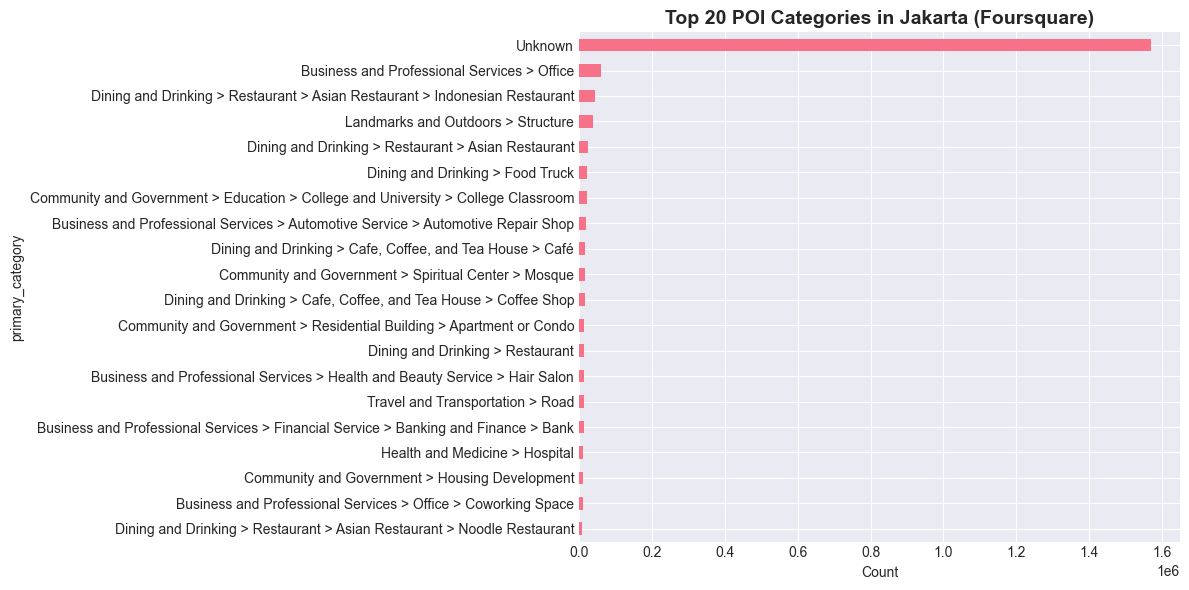

In [7]:
# Top 20 primary categories
print("\n=== Top 20 POI Categories in Jakarta ===")
top_categories = gdf_fsq['primary_category'].value_counts().head(20)
print(top_categories)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
top_categories.plot(kind='barh', ax=ax)
ax.set_xlabel('Count')
ax.set_title('Top 20 POI Categories in Jakarta (Foursquare)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### 1.3 Filter Coffee Shops

In [8]:
# Define coffee-related keywords (case-insensitive)
coffee_keywords = [
    'coffee', 'café', 'cafe', 'kopi', 'espresso', 'barista',
    'coffeehouse', 'coffee shop', 'kafe', 'kedai kopi'
]

def is_coffee_shop(categories_list):
    """Check if any category contains coffee-related keywords"""
    if not categories_list:
        return False
    
    for cat in categories_list:
        cat_lower = str(cat).lower()
        for keyword in coffee_keywords:
            if keyword in cat_lower:
                return True
    return False

print("Filtering coffee shops...")
gdf_fsq['is_coffee_shop'] = gdf_fsq['categories_list'].apply(is_coffee_shop)

# Extract coffee shops
gdf_coffee = gdf_fsq[gdf_fsq['is_coffee_shop']].copy()

print(f"\n✓ Found {len(gdf_coffee):,} coffee shops in Jakarta")
print(f"Percentage: {len(gdf_coffee) / len(gdf_fsq) * 100:.2f}% of all POIs")

Filtering coffee shops...

✓ Found 46,593 coffee shops in Jakarta
Percentage: 1.82% of all POIs


In [9]:
# Coffee shop categories breakdown
print("\n=== Coffee Shop Categories ===")
coffee_cats = gdf_coffee['primary_category'].value_counts().head(15)
print(coffee_cats)

# Sample coffee shop names
print("\n=== Sample Coffee Shop Names ===")
print(gdf_coffee['name'].dropna().sample(min(20, len(gdf_coffee))).tolist())


=== Coffee Shop Categories ===
primary_category
Dining and Drinking > Cafe, Coffee, and Tea House > Café                                                                   17107
Dining and Drinking > Cafe, Coffee, and Tea House > Coffee Shop                                                            15072
Arts and Entertainment > Internet Cafe                                                                                      2093
Dining and Drinking > Cafeteria                                                                                             1969
Community and Government > Education > College and University > College Cafeteria                                           1588
Arts and Entertainment > Gaming Cafe                                                                                        1339
Dining and Drinking > Cafe, Coffee, and Tea House > Bubble Tea Shop                                                         1114
Dining and Drinking > Cafe, Coffee, and Tea Hous

### 1.4 Load Other Datasets

In [10]:
# Load OSM POIs
print("Loading OpenStreetMap POIs...")
osm_path = DATA_DIR / 'osm' / 'jakarta_pois_osm.geojson'
gdf_osm = gpd.read_file(osm_path)
print(f"✓ Loaded {len(gdf_osm):,} OSM POIs")

# Load Buildings
print("\nLoading OSM Buildings...")
buildings_path = DATA_DIR / 'buildings' / 'jakarta_buildings_osm.geojson'
gdf_buildings = gpd.read_file(buildings_path)
print(f"✓ Loaded {len(gdf_buildings):,} buildings")

# Load Administrative Boundaries (District level for now)
print("\nLoading Administrative Boundaries...")
boundaries_path = DATA_DIR / 'boundaries' / 'indonesia_adm3.geojson'
gdf_admin = gpd.read_file(boundaries_path)
# Filter to Jakarta only
jakarta_keywords = ['jakarta', 'dki jakarta', 'kepulauan seribu']
gdf_jakarta = gdf_admin[
    gdf_admin['NAME_1'].str.lower().str.contains('|'.join(jakarta_keywords), na=False)
].copy()
print(f"✓ Loaded {len(gdf_jakarta)} Jakarta districts")

Loading OpenStreetMap POIs...
✓ Loaded 5,071 OSM POIs

Loading OSM Buildings...
✓ Loaded 5,624 buildings

Loading Administrative Boundaries...
✓ Loaded 47 Jakarta districts


## 2. Exploratory Data Analysis

### 2.1 Spatial Distribution Analysis

In [11]:
# Basic statistics
print("=== Jakarta POI Statistics ===")
print(f"Total Foursquare POIs: {len(gdf_fsq):,}")
print(f"Coffee Shops: {len(gdf_coffee):,}")
print(f"OSM POIs: {len(gdf_osm):,}")
print(f"Buildings: {len(gdf_buildings):,}")
print(f"Districts: {len(gdf_jakarta):,}")

# Geographic extent
print(f"\n=== Geographic Extent ===")
print(f"Latitude range: {gdf_fsq['latitude'].min():.4f} to {gdf_fsq['latitude'].max():.4f}")
print(f"Longitude range: {gdf_fsq['longitude'].min():.4f} to {gdf_fsq['longitude'].max():.4f}")

=== Jakarta POI Statistics ===
Total Foursquare POIs: 2,553,079
Coffee Shops: 46,593
OSM POIs: 5,071
Buildings: 5,624
Districts: 47

=== Geographic Extent ===
Latitude range: -6.4000 to -6.0000
Longitude range: 106.6000 to 107.1000


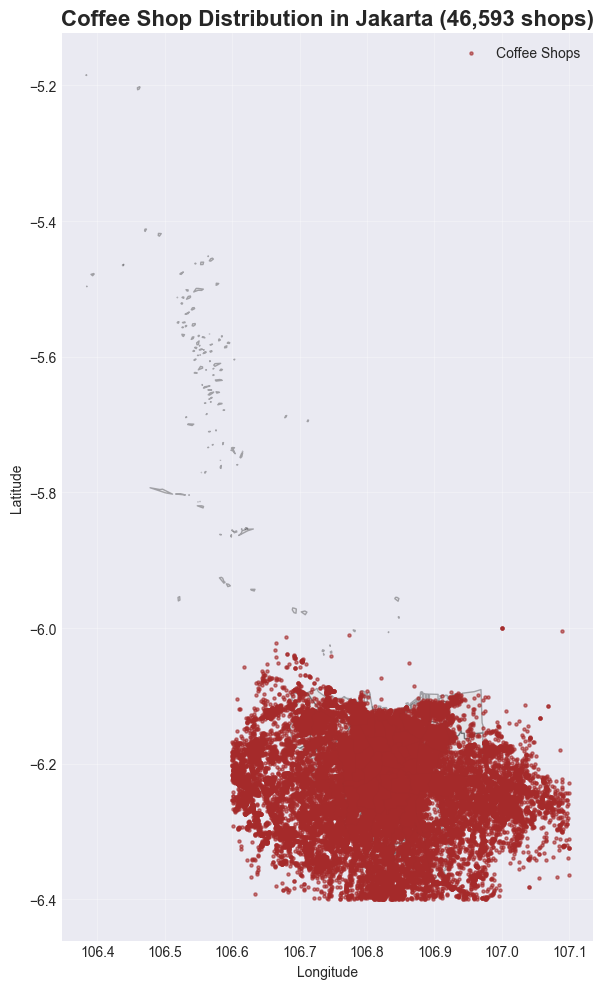

In [12]:
# Static map: Coffee shops distribution
fig, ax = plt.subplots(figsize=(14, 10))

# Plot districts
gdf_jakarta.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.3)

# Plot coffee shops
gdf_coffee.plot(ax=ax, color='brown', markersize=5, alpha=0.6, label='Coffee Shops')

# Styling
ax.set_title(f'Coffee Shop Distribution in Jakarta ({len(gdf_coffee):,} shops)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Interactive map with Folium (sample for performance)
print("Creating interactive map (sampling 1000 coffee shops for performance)...")

# Sample coffee shops
sample_size = min(1000, len(gdf_coffee))
gdf_coffee_sample = gdf_coffee.sample(sample_size)

# Create map centered on Jakarta
jakarta_center = [-6.2, 106.85]
m = folium.Map(location=jakarta_center, zoom_start=11, tiles='OpenStreetMap')

# Add coffee shops with clustering
marker_cluster = MarkerCluster(name='Coffee Shops').add_to(m)

for idx, row in gdf_coffee_sample.iterrows():
    popup_text = f"<b>{row['name']}</b><br>Category: {row['primary_category']}<br>Address: {row['address']}"
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color='brown', icon='coffee', prefix='fa')
    ).add_to(marker_cluster)

# Add layer control
folium.LayerControl().add_to(m)

# Save map
map_path = PROJECT_ROOT / 'outputs' / 'coffee_shops_map.html'
map_path.parent.mkdir(parents=True, exist_ok=True)
m.save(str(map_path))

print(f"✓ Interactive map saved to: {map_path}")
m

Creating interactive map (sampling 1000 coffee shops for performance)...
✓ Interactive map saved to: D:\Script\Project\POI\outputs\coffee_shops_map.html


### 2.2 District-Level Analysis

In [ ]:
# Spatial join: Count coffee shops per district
print("Analyzing coffee shop distribution by district...")

# Reproject to metric CRS for accurate spatial joins
gdf_jakarta_utm = gdf_jakarta.to_crs(epsg=32748)  # WGS 84 / UTM zone 48S (Jakarta)
gdf_coffee_utm = gdf_coffee.to_crs(epsg=32748)

# Spatial join
coffee_by_district = gpd.sjoin(
    gdf_coffee_utm, 
    gdf_jakarta_utm[['NAME_1', 'NAME_2', 'NAME_3', 'geometry']], 
    how='left', 
    predicate='within'
)

# Count per district
district_counts = coffee_by_district.groupby('NAME_3').size().reset_index(name='coffee_shop_count')
district_counts = district_counts.sort_values('coffee_shop_count', ascending=False)

print("\n=== Top 15 Districts by Coffee Shop Count ===")
print(district_counts.head(15).to_string(index=False))

In [ ]:
# Merge counts back to district geodataframe
gdf_jakarta_stats = gdf_jakarta.merge(
    district_counts, 
    left_on='NAME_3', 
    right_on='NAME_3', 
    how='left'
)
gdf_jakarta_stats['coffee_shop_count'] = gdf_jakarta_stats['coffee_shop_count'].fillna(0)

# Choropleth map
fig, ax = plt.subplots(figsize=(14, 10))

gdf_jakarta_stats.plot(
    column='coffee_shop_count',
    cmap='YlOrRd',
    legend=True,
    legend_kwds={'label': 'Coffee Shop Count', 'orientation': 'horizontal'},
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)

ax.set_title('Coffee Shop Density by District in Jakarta', fontsize=16, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

### 2.3 Missing Data Analysis

In [ ]:
# Check missing values
print("=== Missing Data Analysis ===")
missing_pct = (gdf_coffee.isnull().sum() / len(gdf_coffee) * 100).sort_values(ascending=False)
print("\nMissing values (%) in Coffee Shop data:")
print(missing_pct[missing_pct > 0])

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
missing_pct[missing_pct > 0].plot(kind='barh', ax=ax, color='coral')
ax.set_xlabel('Missing Percentage (%)')
ax.set_title('Missing Values in Coffee Shop Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.4 Locality Analysis

In [ ]:
# Top localities with coffee shops
print("=== Top 20 Localities with Coffee Shops ===")
locality_counts = gdf_coffee['locality'].value_counts().head(20)
print(locality_counts)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
locality_counts.plot(kind='barh', ax=ax, color='saddlebrown')
ax.set_xlabel('Number of Coffee Shops')
ax.set_title('Top 20 Localities with Most Coffee Shops', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 3. Key POI Categories for Feature Engineering

### 3.1 Identify Important POI Types

Based on literature, we need to extract these POI types:
1. **Universities/Campuses** - student customers
2. **Office Buildings** - working professionals
3. **Shopping Malls** - foot traffic
4. **Transportation Hubs** - accessibility
5. **Residential Areas** - local residents
6. **Competitors** - other coffee shops
7. **Complementary Businesses** - restaurants, gyms, coworking spaces

In [ ]:
# Define POI type filters
poi_filters = {
    'university': ['university', 'college', 'kampus', 'universitas', 'polytechnic', 'institut'],
    'office': ['office', 'kantor', 'corporate', 'business center', 'coworking'],
    'mall': ['mall', 'shopping center', 'department store', 'plaza'],
    'transport': ['station', 'stasiun', 'terminal', 'airport', 'mrt', 'krl', 'transjakarta', 'halte'],
    'residential': ['apartment', 'apartemen', 'residence', 'housing', 'perumahan', 'residential'],
    'restaurant': ['restaurant', 'restoran', 'dining', 'food', 'makanan'],
    'gym': ['gym', 'fitness', 'sport', 'olahraga'],
    'bank': ['bank', 'atm', 'financial'],
    'hospital': ['hospital', 'clinic', 'klinik', 'rumah sakit', 'medical'],
    'school': ['school', 'sekolah', 'education', 'pendidikan']
}

def categorize_poi(categories_list, poi_type_filters):
    """Categorize POI based on keywords"""
    if not categories_list:
        return 'other'
    
    categories_str = ' '.join([str(cat).lower() for cat in categories_list])
    
    for poi_type, keywords in poi_type_filters.items():
        for keyword in keywords:
            if keyword in categories_str:
                return poi_type
    
    return 'other'

print("Categorizing all POIs...")
gdf_fsq['poi_type'] = gdf_fsq['categories_list'].apply(
    lambda x: categorize_poi(x, poi_filters)
)

# Count by POI type
print("\n=== POI Type Distribution ===")
poi_type_counts = gdf_fsq['poi_type'].value_counts()
print(poi_type_counts)

In [ ]:
# Visualize POI type distribution
fig, ax = plt.subplots(figsize=(12, 6))
poi_type_counts[poi_type_counts.index != 'other'].plot(kind='bar', ax=ax, color='steelblue')
ax.set_ylabel('Count')
ax.set_xlabel('POI Type')
ax.set_title('Distribution of Key POI Types in Jakarta', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Extract key POI types
print("\n=== Extracting Key POI Types ===")

poi_extracts = {}
for poi_type in poi_filters.keys():
    poi_extracts[poi_type] = gdf_fsq[gdf_fsq['poi_type'] == poi_type].copy()
    print(f"{poi_type.capitalize()}: {len(poi_extracts[poi_type]):,} POIs")

# Save for later use
print("\n✓ Key POI types extracted and ready for feature engineering")

## 4. Save Processed Data

In [ ]:
# Save coffee shops dataset
output_dir = PROJECT_ROOT / 'data' / 'processed' / 'coffee_shops'
output_dir.mkdir(parents=True, exist_ok=True)

print("Saving processed datasets...")

# Save coffee shops
coffee_csv = output_dir / 'jakarta_coffee_shops.csv'
gdf_coffee.drop('geometry', axis=1).to_csv(coffee_csv, index=False)
print(f"✓ Saved: {coffee_csv}")

coffee_geojson = output_dir / 'jakarta_coffee_shops.geojson'
gdf_coffee.to_file(coffee_geojson, driver='GeoJSON')
print(f"✓ Saved: {coffee_geojson}")

# Save POI type extracts
for poi_type, gdf in poi_extracts.items():
    if len(gdf) > 0:
        poi_csv = output_dir / f'jakarta_{poi_type}_pois.csv'
        gdf.drop('geometry', axis=1).to_csv(poi_csv, index=False)
        print(f"✓ Saved: {poi_csv}")

print("\n✓ All processed data saved!")

## 5. Summary and Next Steps

In [ ]:
print("="*60)
print("EXPLORATORY DATA ANALYSIS - SUMMARY")
print("="*60)
print(f"\n📊 Data Loaded:")
print(f"  - Foursquare POIs: {len(gdf_fsq):,}")
print(f"  - Coffee Shops: {len(gdf_coffee):,}")
print(f"  - OSM POIs: {len(gdf_osm):,}")
print(f"  - Buildings: {len(gdf_buildings):,}")
print(f"  - Districts: {len(gdf_jakarta):,}")

print(f"\n🎯 Key POI Types Identified:")
for poi_type, gdf in poi_extracts.items():
    print(f"  - {poi_type.capitalize()}: {len(gdf):,}")

print(f"\n📍 Top 3 Districts with Most Coffee Shops:")
for idx, row in district_counts.head(3).iterrows():
    print(f"  {idx+1}. {row['NAME_3']}: {row['coffee_shop_count']:.0f} shops")

print(f"\n✅ Next Steps:")
print(f"  1. Feature Engineering:")
print(f"     - Proximity features (distance to universities, offices, malls)")
print(f"     - Density features (count within 500m/1km/2km buffers)")
print(f"     - Competitor analysis (nearby coffee shop count)")
print(f"     - Population density from WorldPop raster")
print(f"     - Demographics from BPS data")
print(f"\n  2. Label Coffee Shops (Success/Failure):")
print(f"     - Use date_closed for closed shops")
print(f"     - Use popularity/rating as proxy")
print(f"     - Duration of operation")
print(f"\n  3. Grid-Based Analysis:")
print(f"     - Create 100m x 100m grid")
print(f"     - Aggregate features to grid cells")
print(f"     - Prepare training dataset")
print(f"\n  4. Model Development:")
print(f"     - Random Forest baseline")
print(f"     - XGBoost optimization")
print(f"     - SHAP interpretation")
print("="*60)